In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
META_CSV = "HAM10000/metadata.csv"
df = pd.read_csv(META_CSV)
diagnosis_conversion = pd.read_json('HAM10000/diagnosis_conversion.json', typ='series')
df['diagnosis'] = df['diagnosis_2'].map(diagnosis_conversion)
df.rename(columns=({"isic_id": "image_id"}), inplace=True)

In [3]:
# Add full image path for each row
IMG_DIR = "HAM10000/images/"
df["filepath"] = df["image_id"].apply(lambda x: IMG_DIR + f"{x}.jpg")

In [4]:
print("Class distribution:")
print(df["diagnosis"].value_counts())

Class distribution:
diagnosis
nv       7737
bkl      1338
mel      1305
bcc       622
akiec     378
vasc      180
df        160
Name: count, dtype: int64


In [5]:
label_map = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4,'nv':5,'vasc':6}
df["label"] = df["diagnosis"].map(label_map)

In [6]:
df = df[["image_id", "lesion_id", "diagnosis", "filepath", "label"]]

In [7]:
df.head()

,image_id,lesion_id,diagnosis,filepath,label
0,ISIC_0024306,IL_7252831,nv,HAM10000/images/ISIC_0024306.jpg,5
1,ISIC_0024307,IL_6125741,nv,HAM10000/images/ISIC_0024307.jpg,5
2,ISIC_0024308,IL_3692653,nv,HAM10000/images/ISIC_0024308.jpg,5
3,ISIC_0024309,IL_0959663,nv,HAM10000/images/ISIC_0024309.jpg,5
4,ISIC_0024310,IL_8194852,mel,HAM10000/images/ISIC_0024310.jpg,4


In [8]:
df["diagnosis"].value_counts()

diagnosis
nv       7737
bkl      1338
mel      1305
bcc       622
akiec     378
vasc      180
df        160
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

# ---- Build a stable group key (lesion_id, fallback to image_id) ----
groups_all = df["lesion_id"].astype("object")
mask = groups_all.isna() | (groups_all == "")
groups_all[mask] = df.loc[mask, "image_id"].astype(str)
df["group_key"] = groups_all.astype(str)

# ---- Stratified split at the GROUP level to get a fixed test ratio ----
# One row per group with its label
g = df.groupby("group_key", as_index=False).agg(label=("label", "first"))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # <-- test_size here
g_trainval_idx, g_test_idx = next(sss.split(g, g["label"]))

trainval_groups = set(g.loc[g_trainval_idx, "group_key"])
test_groups     = set(g.loc[g_test_idx, "group_key"])

# Map group selection back to rows
trainval_idx = df["group_key"].isin(trainval_groups).to_numpy().nonzero()[0]
test_idx     = df["group_key"].isin(test_groups).to_numpy().nonzero()[0]

trainval_df = df.iloc[trainval_idx].reset_index(drop=True)
test_df     = df.iloc[test_idx].reset_index(drop=True)

# sanity checks: no leakage
assert set(trainval_df["group_key"]).isdisjoint(set(test_df["group_key"]))
print("train+val:", len(trainval_df), " | test:", len(test_df))

train+val: 9349  | test: 2371


In [10]:
from sklearn.model_selection import GroupKFold

# ---- 5-fold CV on trainval_df (grouped) ----
groups_tv = trainval_df["group_key"]

gkf = GroupKFold(n_splits=5)
tr_idx, va_idx = next(gkf.split(trainval_df, trainval_df["label"], groups_tv))  # take 1st fold as val

train_df = trainval_df.iloc[tr_idx].reset_index(drop=True)
val_df   = trainval_df.iloc[va_idx].reset_index(drop=True)

# sanity checks: no overlap
assert set(train_df["group_key"]).isdisjoint(set(val_df["group_key"]))
print("train:", len(train_df), " | val:", len(val_df), " | test:", len(test_df))

train: 7479  | val: 1870  | test: 2371


In [11]:
test_df["diagnosis"].value_counts()

diagnosis
nv       1558
bkl       278
mel       262
bcc       123
akiec      74
vasc       41
df         35
Name: count, dtype: int64

In [12]:
train_df["diagnosis"].value_counts()

diagnosis
nv       4962
mel       837
bkl       816
bcc       405
akiec     243
vasc      115
df        101
Name: count, dtype: int64

In [13]:
val_df["diagnosis"].value_counts()

diagnosis
nv       1217
bkl       244
mel       206
bcc        94
akiec      61
df         24
vasc       24
Name: count, dtype: int64

In [14]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

NUM_CLASSES = 7
classes = np.arange(NUM_CLASSES)

cw = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values
)
class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
class_weights


{0: 4.396825396825397,
 1: 2.638095238095238,
 2: 1.3093487394957983,
 3: 10.578500707213578,
 4: 1.2764976958525345,
 5: 0.21532216272240456,
 6: 9.290683229813665}

In [15]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_CLASSES = 7

def decode_and_resize(path):
    x = tf.io.read_file(path)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.convert_image_dtype(x, tf.float32)  # [0,1]

    h = tf.shape(x)[0]
    w = tf.shape(x)[1]
    side = tf.minimum(h, w)
    offset_h = (h - side) // 2
    offset_w = (w - side) // 2
    x = tf.image.crop_to_bounding_box(x, offset_h, offset_w, side, side)  # center square

    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    return x

def map_train(path, y):
    x = decode_and_resize(path)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, 0.1)
    x = tf.image.random_contrast(x, 0.9, 1.1)
    return x, tf.one_hot(y, depth=NUM_CLASSES)

def map_eval(path, y):
    x = decode_and_resize(path)
    return x, tf.one_hot(y, depth=NUM_CLASSES)

def make_ds(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(paths), seed=42, reshuffle_each_iteration=True)
        ds = ds.map(map_train, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(map_eval,  num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(train_df["filepath"].values, train_df["label"].values, training=True)
val_ds   = make_ds(val_df["filepath"].values,   val_df["label"].values,   training=False)
test_ds  = make_ds(test_df["filepath"].values,  test_df["label"].values,  training=False)


2025-11-11 22:48:23.752156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-11 22:48:23.765712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-11 22:48:23.769579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1762901304.906405    1410 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762901304.911056    1410 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have be

In [16]:
def plot_AUC(history):
    plt.figure()
    plt.plot(history.history["auc"], label="train auc")
    plt.plot(history.history["val_auc"], label="val auc")
    plt.legend(); plt.title("AUC"); plt.xlabel("epoch"); plt.ylabel("auc"); plt.show()

In [17]:
from sklearn.metrics import classification_report

target_names=["akiec","bcc","bkl","df","mel","nv","vasc"]

def classification_report_display(y_true, y_pred):
    print(classification_report(
    y_true,
    y_pred,
    target_names=target_names
))

In [18]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_display(y_true, y_pred):
    print(confusion_matrix(y_true, y_pred))

In [19]:
IMG_SIZE = 256
NUM_CLASSES = 7

model_base = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
])

model_base.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, num_labels=NUM_CLASSES, name="auc")
    ],
)

cb_base = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=1/3, patience=2, verbose=1),
]

In [20]:
history_base = model_base.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=cb_base,
    verbose=1
)


Epoch 1/30


I0000 00:00:1762901307.048536    1456 service.cc:146] XLA service 0x7d67b4005ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762901307.048570    1456 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9


  5/234 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.4071 - loss: 2.3673

I0000 00:00:1762901311.181872    1456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234/234 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - auc: 0.4885 - loss: 1.9523 - val_auc: 0.5936 - val_loss: 1.9299 - learning_rate: 0.0010
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - auc: 0.6075 - loss: 1.8529 - val_auc: 0.7193 - val_loss: 1.6410 - learning_rate: 0.0010
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - auc: 0.6600 - loss: 1.8232 - val_auc: 0.7599 - val_loss: 1.5942 - learning_rate: 0.0010
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - auc: 0.6964 - loss: 1.8622 - val_auc: 0.7884 - val_loss: 1.5398 - learning_rate: 0.0010
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - auc: 0.7160 - loss: 1.7516 - val_auc: 0.8049 - val_loss: 1.4776 - learning_rate: 0.0010
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - auc: 0.7495 - loss: 1.6919 - val_auc: 0.8128 - val_loss: 1.3926 - learning_rate: 0.0010
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - auc: 0.7509 - loss: 1.7127 - val_auc: 0.8049 - val_loss: 1.5279 - learning_rate: 0.0010
Epoch 8/3

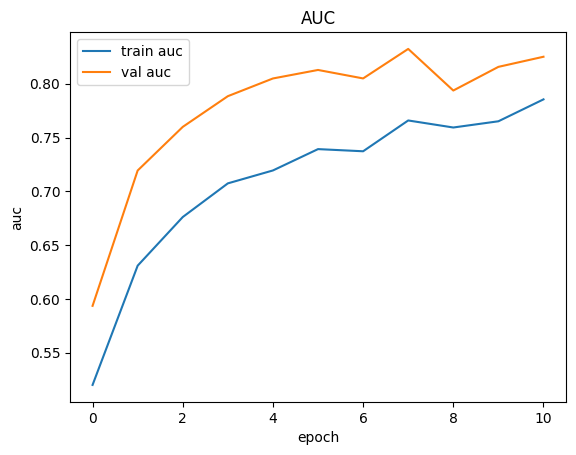

In [21]:
plot_AUC(history_base)

In [22]:
y_true = val_df["label"].values
probs  = model_base.predict(val_ds, verbose=0)
y_pred = probs.argmax(1)

classification_report_display(y_true, y_pred)

confusion_matrix_display(y_true, y_pred)

              precision    recall  f1-score   support

       akiec       0.17      0.31      0.22        61
         bcc       0.30      0.45      0.36        94
         bkl       0.28      0.36      0.31       244
          df       0.19      0.29      0.23        24
         mel       0.25      0.70      0.37       206
          nv       0.95      0.51      0.67      1217
        vasc       0.71      0.71      0.71        24

    accuracy                           0.50      1870
   macro avg       0.41      0.48      0.41      1870
weighted avg       0.71      0.50      0.55      1870

[[ 19   8  12   2  16   4   0]
 [ 17  42  18   5   5   4   3]
 [ 22  34  88   7  78  15   0]
 [  6   6   3   7   1   1   0]
 [  4   6  40   3 145   8   0]
 [ 41  38 157  12 342 623   4]
 [  0   4   2   0   1   0  17]]


In [23]:
base_B0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_B0.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_B0(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model_B0 = tf.keras.Model(inputs, outputs)

model_B0.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, num_labels=NUM_CLASSES, name="auc")
    ],
)

cb_B0 = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=1/3, patience=2, verbose=1),
]

In [24]:
history_B0 = model_B0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=cb_base,
    verbose=1
)


Epoch 1/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 56s 159ms/step - auc: 0.6637 - loss: 1.7618 - val_auc: 0.8340 - val_loss: 1.4157 - learning_rate: 0.0010
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - auc: 0.8291 - loss: 1.3946 - val_auc: 0.8606 - val_loss: 1.3150 - learning_rate: 0.0010
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - auc: 0.8586 - loss: 1.2882 - val_auc: 0.8684 - val_loss: 1.1661 - learning_rate: 0.0010
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - auc: 0.8706 - loss: 1.2096 - val_auc: 0.8706 - val_loss: 1.3025 - learning_rate: 0.0010
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - auc: 0.8821 - loss: 1.1374 - val_auc: 0.8858 - val_loss: 1.0850 - learning_rate: 0.0010
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - auc: 0.8864 - loss: 1.1706 - val_auc: 0.8862 - val_loss: 1.0797 - learning_rate: 0.0010
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - auc: 0.8911 - loss: 1.0934 - val_auc: 0.8925 - val_loss: 0.9981 - learning_rate:

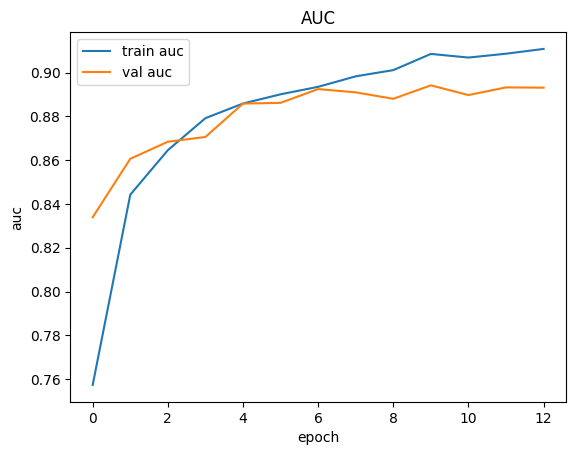

In [25]:
plot_AUC(history_B0)

In [26]:
y_true = val_df["label"].values
probs  = model_B0.predict(val_ds, verbose=0)
y_pred = probs.argmax(1)

classification_report_display(y_true, y_pred)

confusion_matrix_display(y_true, y_pred)

              precision    recall  f1-score   support

       akiec       0.27      0.57      0.37        61
         bcc       0.38      0.60      0.46        94
         bkl       0.52      0.39      0.44       244
          df       0.09      0.50      0.16        24
         mel       0.36      0.52      0.43       206
          nv       0.94      0.72      0.81      1217
        vasc       0.36      0.88      0.51        24

    accuracy                           0.64      1870
   macro avg       0.42      0.60      0.45      1870
weighted avg       0.75      0.64      0.68      1870

[[ 35   9   6   5   4   1   1]
 [ 15  56   6   7   5   2   3]
 [ 33  25  94  18  41  25   8]
 [  1   4   3  12   0   4   0]
 [ 28  14  21  10 108  20   5]
 [ 17  39  52  76 142 871  20]
 [  0   0   0   1   0   2  21]]


In [27]:
# Unfreeze top layers
base_B0.trainable = True
for layer in base_B0.layers[:-30]:
    layer.trainable = False

# Re-compile with a smaller LR
model_B0.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, num_labels=NUM_CLASSES, name="auc")
    ],
)


cb_B0 = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1),
]

In [28]:
history_B0 = model_B0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=cb_base,
    verbose=1
)


Epoch 1/30


E0000 00:00:1762901606.332908    1454 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762901606.516775    1454 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762901606.705909    1454 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762901606.886543    1454 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762901607.074432    1454 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-

233/234 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.8364 - loss: 1.3694

E0000 00:00:1762901625.111056    1456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762901625.301684    1456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762901625.478528    1456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


234/234 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - auc: 0.8367 - loss: 1.3680 - val_auc: 0.9029 - val_loss: 1.0992 - learning_rate: 1.0000e-04
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - auc: 0.9117 - loss: 0.9390 - val_auc: 0.9183 - val_loss: 0.9924 - learning_rate: 1.0000e-04
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - auc: 0.9297 - loss: 0.7541 - val_auc: 0.9257 - val_loss: 0.9084 - learning_rate: 1.0000e-04
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - auc: 0.9410 - loss: 0.7048 - val_auc: 0.9277 - val_loss: 0.8357 - learning_rate: 1.0000e-04
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - auc: 0.9545 - loss: 0.5727 - val_auc: 0.9300 - val_loss: 0.8435 - learning_rate: 1.0000e-04
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - auc: 0.9601 - loss: 0.5186
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.33333324912625e-05.
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - auc: 0.9601 - loss: 0.5187 - val_auc: 0.9264 - val_loss: 0.8578 - le

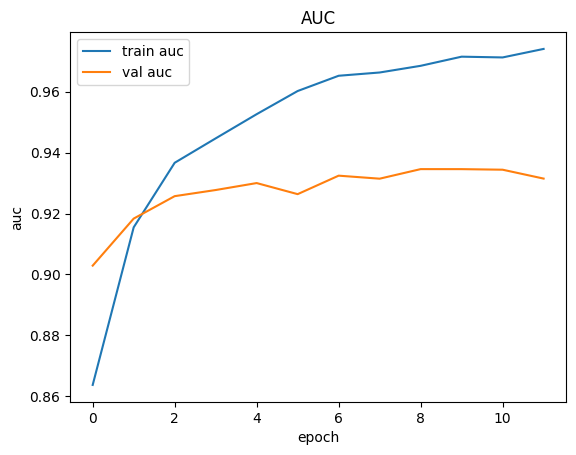

In [29]:
plot_AUC(history_B0)

In [30]:
y_true = val_df["label"].values
probs  = model_B0.predict(val_ds, verbose=0)
y_pred = probs.argmax(1)

print("VALIDATION SET RESULTS BEFORE THRESHOLD TUNING\n")

classification_report_display(y_true, y_pred)

confusion_matrix_display(y_true, y_pred)

VALIDATION SET RESULTS BEFORE THRESHOLD TUNING

              precision    recall  f1-score   support

       akiec       0.38      0.62      0.47        61
         bcc       0.60      0.66      0.63        94
         bkl       0.59      0.55      0.57       244
          df       0.25      0.54      0.35        24
         mel       0.36      0.60      0.45       206
          nv       0.94      0.78      0.85      1217
        vasc       0.55      0.92      0.69        24

    accuracy                           0.72      1870
   macro avg       0.52      0.67      0.57      1870
weighted avg       0.78      0.72      0.74      1870

[[ 38   6   6   2   9   0   0]
 [ 13  62   4   7   4   2   2]
 [ 19  17 134   3  52  16   3]
 [  4   1   3  13   0   3   0]
 [ 15   1  21   7 123  35   4]
 [ 12  16  60  19 153 948   9]
 [  0   0   1   0   0   1  22]]


In [31]:
y_true = test_df["label"].values
probs  = model_B0.predict(test_ds, verbose=0)
y_pred = probs.argmax(1)

print("TEST SET RESULTS BEFORE THRESHOLD TUNING\n")

classification_report_display(y_true, y_pred)

confusion_matrix_display(y_true, y_pred)

TEST SET RESULTS BEFORE THRESHOLD TUNING

              precision    recall  f1-score   support

       akiec       0.28      0.59      0.38        74
         bcc       0.49      0.62      0.55       123
         bkl       0.51      0.56      0.54       278
          df       0.39      0.77      0.51        35
         mel       0.41      0.61      0.49       262
          nv       0.96      0.76      0.85      1558
        vasc       0.66      0.85      0.74        41

    accuracy                           0.71      2371
   macro avg       0.53      0.68      0.58      2371
weighted avg       0.79      0.71      0.73      2371

[[  44   12    8    4    4    2    0]
 [  19   76    7    3   11    4    3]
 [  46    9  157    6   45   13    2]
 [   2    0    1   27    2    1    2]
 [  19    9   38    3  161   31    1]
 [  28   46   92   27  174 1181   10]
 [   0    3    3    0    0    0   35]]


In [32]:
from sklearn.metrics import precision_recall_curve

probs_val = model_B0.predict(val_ds, verbose=0)  # (N_val, 7)
y_true_val = val_df["label"].values              # (N_val,)
C = NUM_CLASSES
best_thresholds = np.zeros(C, dtype=np.float32)

for c in range(C):
    y_true_c = (y_true_val == c).astype(int)
    prec, rec, thr = precision_recall_curve(y_true_c, probs_val[:, c])
    # f1 has same length as prec/rec; thr has length-1
    f1 = (2 * prec * rec) / (prec + rec + 1e-9)
    # ignore the first point (threshold = +inf, typically all negatives)
    j = np.argmax(f1[1:]) + 1
    best_thresholds[c] = thr[j-1]  # align f1 index to thr index


print(best_thresholds)


[0.4655009  0.37088647 0.335335   0.62548566 0.5186358  0.07856643
 0.93893784]


In [33]:
def predict_with_thresholds(probs, thresholds):
    preds = []
    for row in probs:
        # classes that pass their own threshold
        passed = np.where(row >= thresholds)[0]
        if passed.size > 0:
            # pick the passed class with the highest prob
            preds.append(passed[np.argmax(row[passed])])
        else:
            # fallback to argmax if none pass
            preds.append(int(np.argmax(row)))
    return np.array(preds)

In [34]:
y_pred_val_tuned  = predict_with_thresholds(probs_val, best_thresholds)

print("VALIDATION SET RESULTS AFTER THRESHOLD TUNING\n")

classification_report_display(y_true_val, y_pred_val_tuned)

confusion_matrix_display(y_true_val, y_pred_val_tuned)

VALIDATION SET RESULTS AFTER THRESHOLD TUNING

              precision    recall  f1-score   support

       akiec       0.41      0.59      0.49        61
         bcc       0.62      0.69      0.66        94
         bkl       0.58      0.59      0.59       244
          df       0.31      0.50      0.38        24
         mel       0.42      0.50      0.46       206
          nv       0.92      0.84      0.88      1217
        vasc       0.70      0.88      0.78        24

    accuracy                           0.75      1870
   macro avg       0.57      0.66      0.60      1870
weighted avg       0.78      0.75      0.76      1870

[[  36    6    7    2    8    2    0]
 [  11   65    4    5    4    3    2]
 [  15   16  145    1   35   30    2]
 [   4    1    2   12    0    5    0]
 [  14    1   28    6  104   51    2]
 [   7   15   62   13   97 1020    3]
 [   0    0    1    0    0    2   21]]


In [35]:
probs_test = model_B0.predict(test_ds, verbose=0)
y_true_test = test_df["label"].values
y_pred_test = predict_with_thresholds(probs_test, best_thresholds)

print("TEST SET RESULTS AFTER THRESHOLD TUNING\n")

classification_report_display(y_true_test, y_pred_test)

confusion_matrix_display(y_true_test, y_pred_test)


TEST SET RESULTS AFTER THRESHOLD TUNING

              precision    recall  f1-score   support

       akiec       0.30      0.58      0.40        74
         bcc       0.50      0.62      0.55       123
         bkl       0.51      0.58      0.54       278
          df       0.49      0.71      0.58        35
         mel       0.48      0.55      0.51       262
          nv       0.94      0.82      0.87      1558
        vasc       0.76      0.78      0.77        41

    accuracy                           0.74      2371
   macro avg       0.57      0.66      0.60      2371
weighted avg       0.78      0.74      0.76      2371

[[  43   11    9    4    3    4    0]
 [  19   76    6    3    9    7    3]
 [  45    8  162    5   35   22    1]
 [   2    1    1   25    2    2    2]
 [  17    9   41    2  144   49    0]
 [  17   43   96   12  108 1278    4]
 [   0    3    3    0    0    3   32]]


In [36]:
import json

# 1) Save model
model_B0.save("../backend/models/HAM10000_efficientnetB0.keras")  # Keras 3 format

# 2) Save thresholds and metadata
meta = {
    "img_size": 256,
    "class_names": ["akiec","bcc","bkl","df","mel","nv","vasc"],
    "thresholds": [float(x) for x in best_thresholds],  # from the tuned array
    "preprocess": "inputs * 255.0 -> tf.keras.applications.efficientnet.preprocess_input"
}
with open("../backend/models/HAM10000_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
